In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
import gpplot as gpp
import warnings
import pandas as pd
import numpy as np
import statistics
import scipy.stats as stats
from scipy.stats import spearmanr
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams.update({'font.size': 7})
gpp.set_aesthetics(context = 'paper')
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore") 

In [3]:
def p_val_pairwise(tracr_type, model):
    """Perform one-sided t test between the selected RS3 and other methods
    :tracr_type: The Tracr used to train RS3  (Hsu or Chen)
    :tracr_corr: correlation table from model_comp_df. It should match the tracrRNA from tracr_type.
    """
    base = list(model.columns)
    for col in model.columns:
        if 'RS3(Seq+Target)' in col:
            if tracr_type in col:    
                a = col
    base = list(set(model.columns) - set([a,'Gene Symbol','Model']))
    pval_df = pd.DataFrame([])
    for b in base:
        sum_stat = stats.ttest_ind(model[a], model[b],  alternative='greater')
        pval = sum_stat[1]
        pval_df = pval_df.append({'Model':b,'P-value':pval},ignore_index=True)
    #pval_df.to_csv('../data/'+a+'_pval.csv',index=False)
    return(pval_df)
  
def dist_rs3(Tracr):
    """Output a table that displays percent of all sgRNAs targeting essential and non-essential 
     genes broken down by Rule Set 3 (Sequence + Target) bins for the Hsu or Chen tracrRNAs.
    
    :Tracr: Hsu or Chen tracrRNA (Hsu or Chen)
    """
    x = "ess_bin"
    y = 'proportion'
    test_lla = t_data
    test_lla.loc[test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] <= -1, 'ess_bin'] = '<= -1'
    test_lla.loc[(test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] > -1) & 
           (test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] <= -0.5), 'ess_bin'] = '(-1,-0.5]'
    test_lla.loc[(test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] > -0.5) & 
           (test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] <= 0.5), 'ess_bin'] = '(-0.5,0.5]'
    test_lla.loc[(test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] > 0.5) & 
           (test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] <= 1), 'ess_bin'] = '(0.5,1]'
    test_lla.loc[(test_lla['RS3 Sequence (' + Tracr + '2013 tracr) + Target Score'] > 1), 'ess_bin'] = '> 1'
    nen_bar = test_lla[(test_lla.Category == 'Essential') |(test_lla.Category == 'Non-essential')]
    prop_table = nen_bar[x].value_counts().rename(y).reset_index()
    prop_table.proportion = prop_table[['proportion']].apply(lambda x: x/x.sum(), axis=0)*100
    prop_table['Tracr'] = Tracr
    return prop_table

def cum_fraction_quintile(Tracr_RS3, Tracr_lfc, Tracr_year, plot = False, min_guide = 20, category = 'Essential'):
    """Table or figure for the percent of quintiles for sgRNAs from genes binned by 
    Rule Set 3 (Sequence + Target) scores for each screen. 
    
    :Tracr_RS3: RS3 trained on Hsu or Chen tracrRNA (Hsu or Chen)
    :Tracr_lfc: Type of Tracr used as the observed LFC (Hsu, Chen, or DeWeirdt)
    :tracr_year: The year the input tracrRNA for LFC is published (2013 or 2020)
    :plot: True outputs graph and False outpus table. The default is False. (True, False)
    :min_guide: The minimal number of guides in a gene that are included
    :category: Genes' category (Essential or Non-essential)

    """
    ess_cum_fra = t_data[t_data['Category'] == category]
    ess_cum_fra.loc[ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']<=-1, 'ess_bin'] = '<= -1'
    ess_cum_fra.loc[(ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']>-1) & 
           (ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']<=-0.5), 'ess_bin'] = '(-1,-0.5]'
    ess_cum_fra.loc[(ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']>-0.5) & 
           (ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']<=0.5), 'ess_bin'] = '(-0.5,0.5]'
    ess_cum_fra.loc[(ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']>0.5) & 
           (ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']<=1), 'ess_bin'] = '(0.5,1]'
    ess_cum_fra.loc[(ess_cum_fra['RS3 Sequence ('+Tracr_RS3+'2013 tracr) + Target Score']>1), 'ess_bin'] = '> 1'
    ess_gene_count = ess_cum_fra['Target Gene Symbol'].value_counts().reset_index()
    master_genes = pd.DataFrame()
    for index, row in ess_gene_count.iterrows():
        if row['Target Gene Symbol'] > min_guide:
            gene = row['index']
            master_guides = pd.DataFrame({'index': ['(-0.5,0.5]', '(0.5,1]', '(-1,-0.5]', '<= -1', '> 1'],
                                        'gene':gene})  
            gene_info = ess_cum_fra[ess_cum_fra['Target Gene Symbol'] == gene]
            for high_percent in [0.2,0.4, 0.6,0.8,1]:
                low_q = gene_info[Tracr_lfc+"_"+Tracr_year+"_lfc"].quantile(high_percent - 0.2)
                high_q = gene_info[Tracr_lfc+"_"+Tracr_year+"_lfc"].quantile(high_percent)
                gene_sel = gene_info[(gene_info[Tracr_lfc+"_"+Tracr_year+"_lfc"] >= low_q) & 
                                     (gene_info[Tracr_lfc+"_"+Tracr_year+"_lfc"] < high_q)].ess_bin.value_counts().reset_index()
                gene_sel.columns = ['index', str(high_percent)]
                gene_sel['gene'] = gene
                master_guides = pd.merge(gene_sel,master_guides,on=['index','gene'],how='outer')
        master_genes = master_genes.append(master_guides)
    master_genes = master_genes.replace(np.nan,0) 
    aaa = master_genes.groupby('index').sum()
    aaa = aaa.reindex(["<= -1", "(-1,-0.5]", "(-0.5,0.5]", "(0.5,1]", "> 1"]).rename({'1': 'Least active', '0.8': '4th quintile','0.6': '3rd quintile', '0.4': '2nd quintile','0.2': 'Most active'}, axis=1)
    aaa = aaa.div(aaa.sum(axis=1), axis=0)*100
    #aaa.to_csv(supp_path+"Figure2d_data/"+Tracr_lfc+".csv")
    if plot == False:
        return aaa
    else:
        fig, ax = plt.subplots(figsize=(2,2))
        r = [0,1,2,3,4]
        barWidth = 0.85
        names = ('< -1','(-1,-0.5]','(-0.5,0.5]','(0.5,1]','> 1')
        plt.bar(r, aaa['Most active'], color='#045a8d', edgecolor='white', width=barWidth, label="Most active")
        plt.bar(r, aaa['2nd quintile'], bottom=aaa['Most active'], color='#2b8cbe', edgecolor='white', width=barWidth, label="4th quintile")
        plt.bar(r, aaa['3rd quintile'], bottom=[i+j for i,j in zip(aaa['Most active'], aaa['2nd quintile'])], color='#74a9cf', edgecolor='white', width=barWidth, label="3rd quintile")
        plt.bar(r, aaa['4th quintile'], bottom=[i+j+z for i,j,z in zip(aaa['Most active'], aaa['2nd quintile'], aaa['3rd quintile'])], color='#a6bddb', edgecolor='white', width=barWidth, label="2nd quintile")
        plt.bar(r, aaa['Least active'], bottom=[i+j+z+w for i,j,z,w in zip(aaa['Most active'], aaa['4th quintile'], aaa['3rd quintile'], aaa['2nd quintile'])], color='#d0d1e6', edgecolor='white', width=barWidth, label="Least active")
        plt.title("Screened with "+Tracr_lfc+" "+Tracr_year) 
        plt.xticks(r, names)
        plt.xticks(rotation=90)
        plt.xlabel("RS3 (Seq + Target) with "+  Tracr_RS3+" feature")
        ax.set_ylim([0, 100])
        plt.ylabel("Percent of Essential Guides")
        plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
        #gpplot.savefig('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/Manuscripts/2021 Rule Set 3 + Aggregate CFD/Figures/PDFs/'+Tracr_lfc+'_essential_percent_stack_v9.pdf', dpi=1000)

In [4]:
import sys
print('Python version: ' + sys.version)
modules = ['pandas','seaborn','gpplot','matplotlib','numpy','scipy']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

Python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
pandas 1.2.4
seaborn 0.11.1
gpplot 0.5.0
matplotlib 3.3.4
numpy 1.20.3
scipy 1.6.3


This notebook is intended to process data, produce graphs and analysis relating to Figure 2 in the Rule Set 3 paper.

1. Filter train data for the anaysis

2. Generate graphs/dataframes for 2b, 2c, 2d

3. Analyze RS3 performance by using pair-wise p-value comparison and summary statistic 

# 1 Import Data

In [5]:
t_data = pd.read_csv("Data/Tiling_Library_lfc_v1.csv")

# overlapping guides used in training
train_overlap_ess = pd.read_table("Data/training_essential_guides_v1.txt")
train_overlap_noness = pd.read_table("Data/training_nonessential_guides_v1.txt")


# 2 Filter out train data


In [6]:
t_data = t_data[~t_data['sgRNA Sequence'].isin(train_overlap_ess['sgRNA Sequence'])]
t_data = t_data[~t_data['sgRNA Sequence'].isin(train_overlap_noness['sgRNA Sequence'])]

# 3 Figure 2b

## 3.1 Correlation table

In [7]:
model_corr = pd.read_excel('Supplementary Data 3 - Figure 2 data_v4.xlsx', sheet_name='Fig 2b')

In [8]:
model_hsu = model_corr[model_corr['Model'] == 'Hsu (2013)']
model_hsu

,Gene Symbol,RS3(Seq+Target)+Chen,RS3(Seq+Target)+Hsu,RS3(Seq)+Chen,RS3(Seq)+Hsu,RS2,VBC,VBC_sgRNA_activity,VBC_Bioscore,DeepSpCas9,CRISPRon,RS3(Target),DeepCRISPR,Model
0,SRCAP,0.454715,0.532636,0.402199,0.470672,0.342999,0.392970,0.358836,0.186881,0.412274,0.468249,0.180406,0.119663,Hsu (2013)
1,GCN1,0.388088,0.491588,0.408753,0.497147,0.395479,0.356498,0.386030,0.053505,0.446241,0.493750,0.002788,0.110998,Hsu (2013)
2,POLE,0.429978,0.565803,0.408314,0.543153,0.450381,0.359490,0.356020,0.188699,0.509203,0.549478,0.139745,0.125274,Hsu (2013)
3,NUP214,0.467673,0.571228,0.373872,0.493857,0.480066,0.453552,0.418558,0.194149,0.430738,0.477814,0.267526,0.136110,Hsu (2013)
4,SON,0.397837,0.451115,0.363087,0.401540,0.434895,0.436572,0.406468,0.125679,0.376497,0.378460,0.165284,0.051258,Hsu (2013)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,KIF11,0.156140,0.478947,0.135088,0.501754,0.612281,0.122861,0.194737,0.026316,0.577193,0.601754,0.178148,-0.019298,Hsu (2013)
196,PET117,0.270175,0.468421,0.078947,0.482456,0.426316,0.252632,0.219298,0.372971,0.394737,0.514035,0.507018,-0.422807,Hsu (2013)
197,CRIPT,0.595459,0.673891,0.680083,0.702786,0.242518,0.281734,0.298246,-0.373774,0.684211,0.723426,-0.422085,0.197110,Hsu (2013)
198,TTK,0.607143,0.642857,0.500000,0.571429,0.321429,0.321429,0.214286,0.428571,0.535714,0.571429,0.535714,-0.107143,Hsu (2013)


In [9]:
model_chen = model_corr[model_corr['Model'] == 'Chen (2013)']
model_chen

,Gene Symbol,RS3(Seq+Target)+Chen,RS3(Seq+Target)+Hsu,RS3(Seq)+Chen,RS3(Seq)+Hsu,RS2,VBC,VBC_sgRNA_activity,VBC_Bioscore,DeepSpCas9,CRISPRon,RS3(Target),DeepCRISPR,Model
200,SRCAP,0.389821,0.291026,0.229337,0.139012,0.079986,0.371603,0.158523,0.352314,0.092149,0.112653,0.327610,0.069082,Chen (2013)
201,GCN1,0.259928,0.191271,0.256862,0.185725,0.096257,0.202577,0.157901,0.079608,0.121214,0.157625,0.022949,0.038095,Chen (2013)
202,POLE,0.346565,0.275102,0.272567,0.202596,0.168103,0.241352,0.154273,0.258876,0.187718,0.190694,0.266806,0.107646,Chen (2013)
203,NUP214,0.374068,0.295259,0.244113,0.185048,0.223549,0.398599,0.244258,0.297440,0.127589,0.155226,0.335868,0.053302,Chen (2013)
204,SON,0.297942,0.154739,0.219568,0.086274,0.146124,0.363788,0.186910,0.197810,0.085437,0.064928,0.281225,-0.007543,Chen (2013)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,KIF11,0.305263,0.128070,0.314035,0.070175,-0.087719,0.082492,0.063158,0.140351,0.103509,0.082456,0.336990,0.349123,Chen (2013)
396,PET117,0.247368,0.361404,0.135088,0.322807,0.356140,0.303509,0.247368,0.563405,0.405263,0.373684,0.566667,-0.119298,Chen (2013)
397,CRIPT,0.314757,0.389061,0.403509,0.420021,0.077399,-0.003096,0.124871,-0.418172,0.323013,0.484004,-0.453044,0.098039,Chen (2013)
398,TTK,0.892857,0.714286,0.785714,0.678571,0.750000,0.821429,0.714286,-0.285714,0.535714,0.678571,0.000000,-0.642857,Chen (2013)


In [10]:
model_deweirdt = model_corr[model_corr['Model'] == 'DeWeirdt (2020)']
model_deweirdt

,Gene Symbol,RS3(Seq+Target)+Chen,RS3(Seq+Target)+Hsu,RS3(Seq)+Chen,RS3(Seq)+Hsu,RS2,VBC,VBC_sgRNA_activity,VBC_Bioscore,DeepSpCas9,CRISPRon,RS3(Target),DeepCRISPR,Model
400,SRCAP,0.482873,0.392653,0.340504,0.253522,0.169839,0.425290,0.244262,0.350627,0.206394,0.227827,0.324032,0.106211,DeWeirdt (2020)
401,GCN1,0.331637,0.249311,0.337181,0.244414,0.146415,0.272322,0.211608,0.124625,0.184297,0.215691,0.025062,0.099360,DeWeirdt (2020)
402,POLE,0.459826,0.326959,0.402683,0.263563,0.226682,0.325855,0.219672,0.281723,0.237004,0.246346,0.228448,0.146075,DeWeirdt (2020)
403,NUP214,0.471917,0.362596,0.342482,0.254556,0.252515,0.455814,0.283404,0.331460,0.198669,0.199431,0.342750,0.054033,DeWeirdt (2020)
404,SON,0.400157,0.254435,0.316410,0.173414,0.226269,0.457405,0.262503,0.262575,0.153402,0.123594,0.301559,-0.004446,DeWeirdt (2020)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,KIF11,-0.194737,-0.207018,-0.063158,-0.089474,-0.340351,-0.236946,-0.173684,-0.059649,-0.005263,-0.029825,-0.016674,-0.050877,DeWeirdt (2020)
596,PET117,0.385965,0.559649,0.185965,0.515789,0.445614,0.294737,0.261404,0.508118,0.391228,0.484211,0.571930,0.056140,DeWeirdt (2020)
597,CRIPT,0.486068,0.498452,0.481940,0.488132,0.153767,0.013416,0.141383,-0.378937,0.391125,0.521156,-0.087719,0.151703,DeWeirdt (2020)
598,TTK,0.642857,0.428571,0.464286,0.392857,0.428571,0.571429,0.392857,-0.107143,0.285714,0.392857,0.250000,-0.642857,DeWeirdt (2020)


## 3.2 P-value table

In [11]:
p_val_pairwise('Chen', model_chen)

,Model,P-value
0,RS3(Seq)+Chen,3.134938e-16
1,RS3(Seq)+Hsu,1.046693e-36
2,RS3(Seq+Target)+Hsu,3.304358e-10
3,RS3(Target),5.219547e-07
4,VBC,5.206672e-04
5,RS2,7.300503e-46
6,VBC_Bioscore,1.096131e-05
7,CRISPRon,5.959074e-42
8,DeepSpCas9,6.761354e-43
9,DeepCRISPR,1.134770e-78


In [12]:
p_val_pairwise('Hsu', model_hsu)

,Model,P-value
0,RS3(Seq)+Chen,3.675415e-34
1,RS3(Seq)+Hsu,1.061667e-07
2,RS3(Target),1.518329e-84
3,VBC,1.695305e-22
4,RS2,4.987496e-27
5,VBC_Bioscore,3.764228e-79
6,CRISPRon,1.812120e-09
7,RS3(Seq+Target)+Chen,4.954897e-16
8,DeepSpCas9,6.083392e-15
9,DeepCRISPR,4.417759e-134


# 4 Figure 2c: Distribution of RS3 

In [13]:
hsu_prop_table = dist_rs3('Hsu')
chen_prop_table = dist_rs3('Chen')
frames = [chen_prop_table, hsu_prop_table]
result = pd.concat(frames)

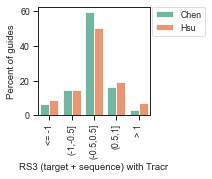

In [14]:
fig, ax = plt.subplots(figsize=(2,2))
ax = sns.barplot(x = "index", y = "proportion", hue = "Tracr", data = result, order = ['<= -1','(-1,-0.5]','(-0.5,0.5]','(0.5,1]','> 1'])
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("RS3 (target + sequence) with Tracr")
ax.set_ylabel('Percent of guides')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# 5 Figure 2d

## 5.1 Quintile table

In [15]:
chen_quintile = cum_fraction_quintile('Chen','Chen','2013')
de_quintile = cum_fraction_quintile('Chen','DeWeirdt','2020')
hsu_quintile = cum_fraction_quintile('Hsu','Hsu','2013')

In [16]:
chen_quintile

,Least active,4th quintile,3rd quintile,2nd quintile,Most active
index,,,,,
<= -1,55.713813,19.211659,11.526996,7.916529,5.631004
"(-1,-0.5]",33.820307,25.025566,18.173850,13.849525,9.130752
"(-0.5,0.5]",16.209660,20.693965,21.715798,21.462177,19.918400
"(0.5,1]",7.665260,14.303797,19.437412,24.556962,34.036568
> 1,4.991948,9.017713,16.988728,25.603865,43.397746


In [17]:
hsu_quintile

,Least active,4th quintile,3rd quintile,2nd quintile,Most active
index,,,,,
<= -1,68.165764,19.543207,7.487638,3.060984,1.742406
"(-1,-0.5]",39.760772,28.058798,16.890042,10.332901,4.957487
"(-0.5,0.5]",12.950358,22.289183,23.971385,22.445263,18.343811
"(0.5,1]",3.816059,11.616709,19.742386,28.120862,36.703985
> 1,1.954625,5.933682,15.148342,25.479930,51.483421


In [18]:
de_quintile

,Least active,4th quintile,3rd quintile,2nd quintile,Most active
index,,,,,
<= -1,63.966667,18.000000,9.533333,5.000000,3.500000
"(-1,-0.5]",37.616822,26.664720,16.764019,12.222547,6.731893
"(-0.5,0.5]",15.073475,21.032329,22.505511,21.836885,19.551800
"(0.5,1]",5.370448,12.245185,19.049627,25.966540,37.368199
> 1,2.735318,7.401448,14.320193,25.100563,50.442478


## 5.1 Quintile plot

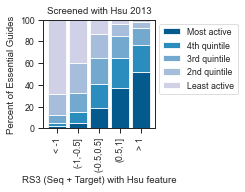

In [19]:
cum_fraction_quintile('Hsu','Hsu','2013', True)

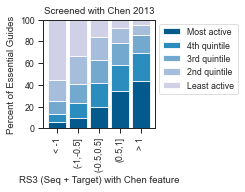

In [20]:
cum_fraction_quintile('Chen','Chen','2013', True)

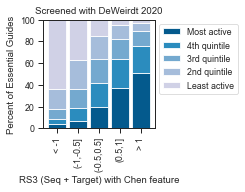

In [21]:
cum_fraction_quintile('Chen','DeWeirdt','2020', True)